# SINDy-SHRED: Stochastic Differential Equation (SDE) Example

This notebook demonstrates SINDy-SHRED on a **stochastic differential equation** (Ornstein-Uhlenbeck process) projected to a high-dimensional observation space.

## Latent Dynamical System

**2D Ornstein-Uhlenbeck Process:**
$$dX_t = -\theta X_t \, dt + \sigma \, dW_t$$

Or in component form:
$$dx = -\theta_x x \, dt + \sigma_x \, dW_x$$
$$dy = -\theta_y y \, dt + \sigma_y \, dW_y$$

where:
- $\theta$ = mean-reversion rate (drift toward zero)
- $\sigma$ = volatility (diffusion coefficient)
- $dW$ = Wiener process (Brownian motion)

**High-dimensional projection:** The 2D latent state $(x, y)$ is projected to a high-dimensional space via a random linear projection matrix.

$$\mathbf{z} = \mathbf{P} \begin{bmatrix} x \\ y \end{bmatrix} + \epsilon$$

## 1. Setup and Imports

In [1]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

# Local modules
from sindy_shred import SINDySHRED
import plotting

warnings.filterwarnings("ignore")

# Create results directory
RESULTS_DIR = "results/sde_example"
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Results will be saved to: {RESULTS_DIR}")

Results will be saved to: results/sde_example


In [2]:
# Device selection
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using device: {device}")

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed(SEED)

Using device: cuda


In [3]:
# Plotting configuration
sns.set_context("paper")
sns.set_style("whitegrid")

pcolor_kwargs = {
    "vmin": -3,
    "vmax": 3,
    "cmap": "RdBu_r",
    "rasterized": True,
}

## 2. Data Generation: Ornstein-Uhlenbeck SDE

We simulate a 2D Ornstein-Uhlenbeck process using the Euler-Maruyama method and project it to high-dimensional observations.

In [4]:
def simulate_ornstein_uhlenbeck_2d(x0, theta, sigma, T, dt, seed=None):
    """
    Simulate 2D Ornstein-Uhlenbeck process using Euler-Maruyama method.
    
    dX = -theta * X * dt + sigma * dW
    
    Parameters:
    -----------
    x0 : array (2,) - Initial condition
    theta : array (2,) - Mean-reversion rates
    sigma : array (2,) - Volatilities
    T : float - Total time
    dt : float - Time step
    seed : int - Random seed
    
    Returns:
    --------
    t : array - Time points
    X : array (n_steps, 2) - Simulated trajectory
    """
    if seed is not None:
        np.random.seed(seed)
    
    n_steps = int(T / dt)
    t = np.linspace(0, T, n_steps)
    X = np.zeros((n_steps, 2))
    X[0] = x0
    
    sqrt_dt = np.sqrt(dt)
    
    for i in range(1, n_steps):
        dW = sqrt_dt * np.random.randn(2)  # Brownian increments
        # Euler-Maruyama: X_{n+1} = X_n + drift*dt + diffusion*dW
        drift = -theta * X[i-1]
        diffusion = sigma
        X[i] = X[i-1] + drift * dt + diffusion * dW
    
    return t, X

# SDE parameters
theta = np.array([0.5, 0.3])   # Mean-reversion rates
sigma = np.array([0.1, 0.1])   # Volatilities
x0 = np.array([1.0, -0.5])     # Initial condition

print("Ornstein-Uhlenbeck SDE Parameters:")
print(f"  Mean-reversion (theta): {theta}")
print(f"  Volatility (sigma): {sigma}")
print(f"  Initial condition: {x0}")
print(f"\nGoverning SDEs:")
print(f"  dx = -{theta[0]}*x*dt + {sigma[0]}*dW_x")
print(f"  dy = -{theta[1]}*y*dt + {sigma[1]}*dW_y")

Ornstein-Uhlenbeck SDE Parameters:
  Mean-reversion (theta): [0.5 0.3]
  Volatility (sigma): [0.1 0.1]
  Initial condition: [ 1.  -0.5]

Governing SDEs:
  dx = -0.5*x*dt + 0.1*dW_x
  dy = -0.3*y*dt + 0.1*dW_y


In [5]:
# Time parameters
T = 100.0
dt_sim = 0.01

# Simulate SDE
t_eval, latent_states = simulate_ornstein_uhlenbeck_2d(
    x0=x0, theta=theta, sigma=sigma, T=T, dt=dt_sim, seed=SEED
)

print(f"Simulated trajectory shape: {latent_states.shape}")
print(f"Time range: [0, {T}]")
print(f"Number of time steps: {len(t_eval)}")

Simulated trajectory shape: (10000, 2)
Time range: [0, 100.0]
Number of time steps: 10000


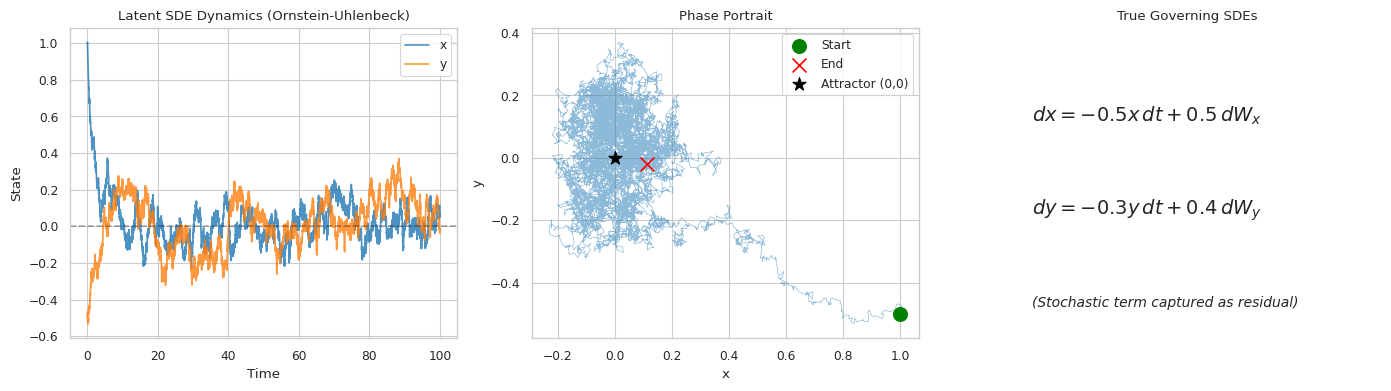

In [6]:
# Visualize the latent SDE dynamics
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Time series
axes[0].plot(t_eval, latent_states[:, 0], alpha=0.8, label='x')
axes[0].plot(t_eval, latent_states[:, 1], alpha=0.8, label='y')
axes[0].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('State')
axes[0].set_title('Latent SDE Dynamics (Ornstein-Uhlenbeck)')
axes[0].legend()

# Phase portrait
axes[1].plot(latent_states[:, 0], latent_states[:, 1], alpha=0.5, linewidth=0.5)
axes[1].scatter([latent_states[0, 0]], [latent_states[0, 1]], c='g', s=100, marker='o', label='Start', zorder=5)
axes[1].scatter([latent_states[-1, 0]], [latent_states[-1, 1]], c='r', s=100, marker='x', label='End', zorder=5)
axes[1].scatter([0], [0], c='k', s=100, marker='*', label='Attractor (0,0)', zorder=5)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Phase Portrait')
axes[1].legend()

# True governing equations
axes[2].text(0.1, 0.7, r'$dx = -0.5x \, dt + 0.5 \, dW_x$', fontsize=14, transform=axes[2].transAxes)
axes[2].text(0.1, 0.4, r'$dy = -0.3y \, dt + 0.4 \, dW_y$', fontsize=14, transform=axes[2].transAxes)
axes[2].text(0.1, 0.1, r'(Stochastic term captured as residual)', fontsize=10, transform=axes[2].transAxes, style='italic')
axes[2].set_title('True Governing SDEs')
axes[2].axis('off')

fig.tight_layout()
fig.savefig(f"{RESULTS_DIR}/latent_sde_dynamics.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [7]:
# Project to high-dimensional space
high_dim = 20  # Observation dimension
obs_noise_std = 0.05  # Additional observation noise

# Random projection matrix
np.random.seed(SEED + 1)
P = np.random.randn(high_dim, 2)
P = P / np.linalg.norm(P, axis=1, keepdims=True)  # Normalize rows

# Project and add observation noise
observations = latent_states @ P.T  # Shape: (n_time, high_dim)
obs_noise = obs_noise_std * np.random.randn(*observations.shape)
observations_noisy = observations + obs_noise

print(f"Observation dimension: {high_dim}")
print(f"Observation noise std: {obs_noise_std}")
print(f"Observations shape: {observations_noisy.shape}")
print(f"\nNote: The SDE has intrinsic stochasticity from dW.")
print(f"SINDy will recover the deterministic drift: dx/dt = -theta*x")

Observation dimension: 20
Observation noise std: 0.05
Observations shape: (10000, 20)

Note: The SDE has intrinsic stochasticity from dW.
SINDy will recover the deterministic drift: dx/dt = -theta*x


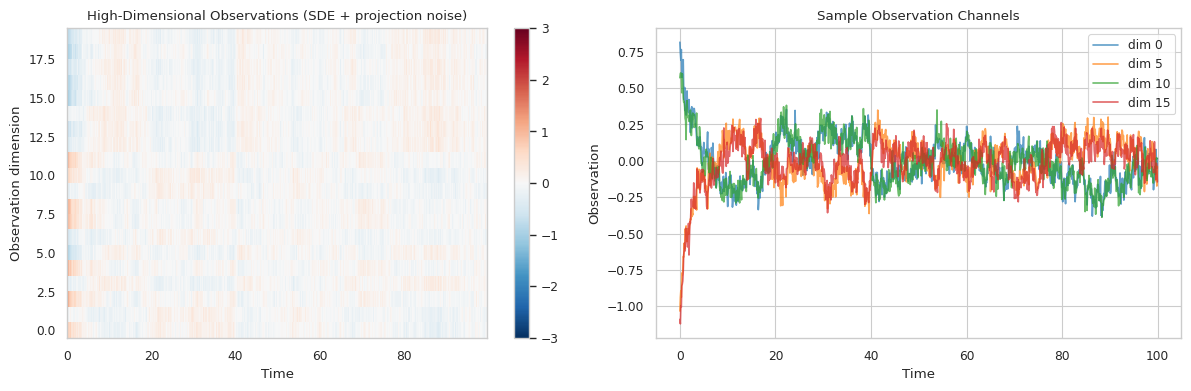

In [8]:
# Visualize high-dimensional observations
data_original = observations_noisy.T  # Shape: (space, time)
space_dim = np.arange(high_dim)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Heatmap (subsample for visualization)
subsample_viz = 10
im = axes[0].pcolormesh(t_eval[::subsample_viz], space_dim, data_original[:, ::subsample_viz], **pcolor_kwargs)
axes[0].set_title('High-Dimensional Observations (SDE + projection noise)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Observation dimension')
plt.colorbar(im, ax=axes[0])

# Sample time series
for i in [0, 5, 10, 15]:
    axes[1].plot(t_eval[::subsample_viz], observations_noisy[::subsample_viz, i], alpha=0.7, label=f'dim {i}')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Observation')
axes[1].set_title('Sample Observation Channels')
axes[1].legend()

fig.tight_layout()
fig.savefig(f"{RESULTS_DIR}/observations.pdf", bbox_inches="tight", dpi=300)
plt.show()

## 3. Model Training with SINDy-SHRED

**Important note:** SINDy discovers the deterministic part of the dynamics (the drift term). The stochastic diffusion term will appear as residual/noise in the identified system.

In [9]:
# Sensor configuration
num_sensors = 3
sensor_locations = np.array([0, 7, 14])  # Select 3 observation channels as sensors

# Data parameters
subsample = 5  # Subsample for efficiency
dt = dt_sim * subsample

# Prepare data
data = observations_noisy[::subsample, :]
n_time = data.shape[0]

print(f"Subsampled data shape: {data.shape}")
print(f"Effective dt: {dt}")
print(f"Sensor locations: {sensor_locations}")

Subsampled data shape: (2000, 20)
Effective dt: 0.05
Sensor locations: [ 0  7 14]


In [10]:
# Initialize SINDy-SHRED model
model = SINDySHRED(
    latent_dim=2,       # Match true latent dimension
    poly_order=1,       # Linear drift -> degree 1 sufficient
    hidden_layers=2,
    l1=64,
    l2=64,
    dropout=0.1,
    batch_size=64,
    num_epochs=200,
    lr=1e-3,
    threshold=0.05,
    sindy_regularization=5.0,
)

print("SINDy-SHRED model initialized")
print("Note: Using poly_order=1 since OU process has linear drift")

SINDy-SHRED model initialized
Note: Using poly_order=1 since OU process has linear drift


In [11]:
# Fit the model
train_length = int(n_time * 0.6)
validate_length = int(n_time * 0.1)

model.fit(
    num_sensors=num_sensors,
    dt=dt,
    x_to_fit=data,
    lags=30,
    train_length=train_length,
    validate_length=validate_length,
    sensor_locations=sensor_locations,
)

print("\nModel training complete!")

1 : tensor(0.1558, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.0921, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0207, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0145, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0115, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0119, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0122, device='cuda:

## 4. SINDy Discovery

SINDy will identify the deterministic drift term of the SDE. The stochastic component is not explicitly modeled but appears as prediction uncertainty.

SINDy-derived dynamical equation (1st order):

(x0)' =  0.077 1 +  3.232 x0 +  3.210 x1
(x1)' = -0.083 1 + -3.480 x0 + -3.275 x1


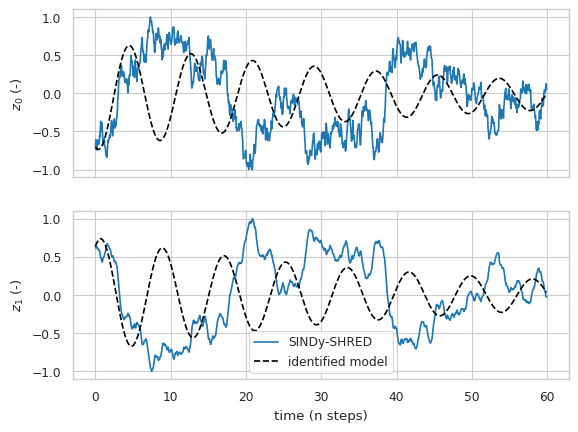


TRUE DRIFT EQUATIONS (deterministic part):
dx/dt = -0.5*x
dy/dt = -0.3*y

(Stochastic term sigma*dW is not recovered by SINDy)


In [12]:
# Perform SINDy identification
model.sindy_identify(threshold=0.05, plot_result=True)

print("\n" + "="*50)
print("TRUE DRIFT EQUATIONS (deterministic part):")
print("="*50)
print(f"dx/dt = -{theta[0]}*x")
print(f"dy/dt = -{theta[1]}*y")
print("\n(Stochastic term sigma*dW is not recovered by SINDy)")

Stochastic SINDy-derived dynamics:

Reconstruction MSE: 2.164e-03
sigma_0^2(X): (x0)' =  0.077 1
mu_0(X): (x0)' = -0.336 x0
sigma_1^2(X): (x0)' =  0.010 1
mu_1(X): (x0)' = -0.035 x0


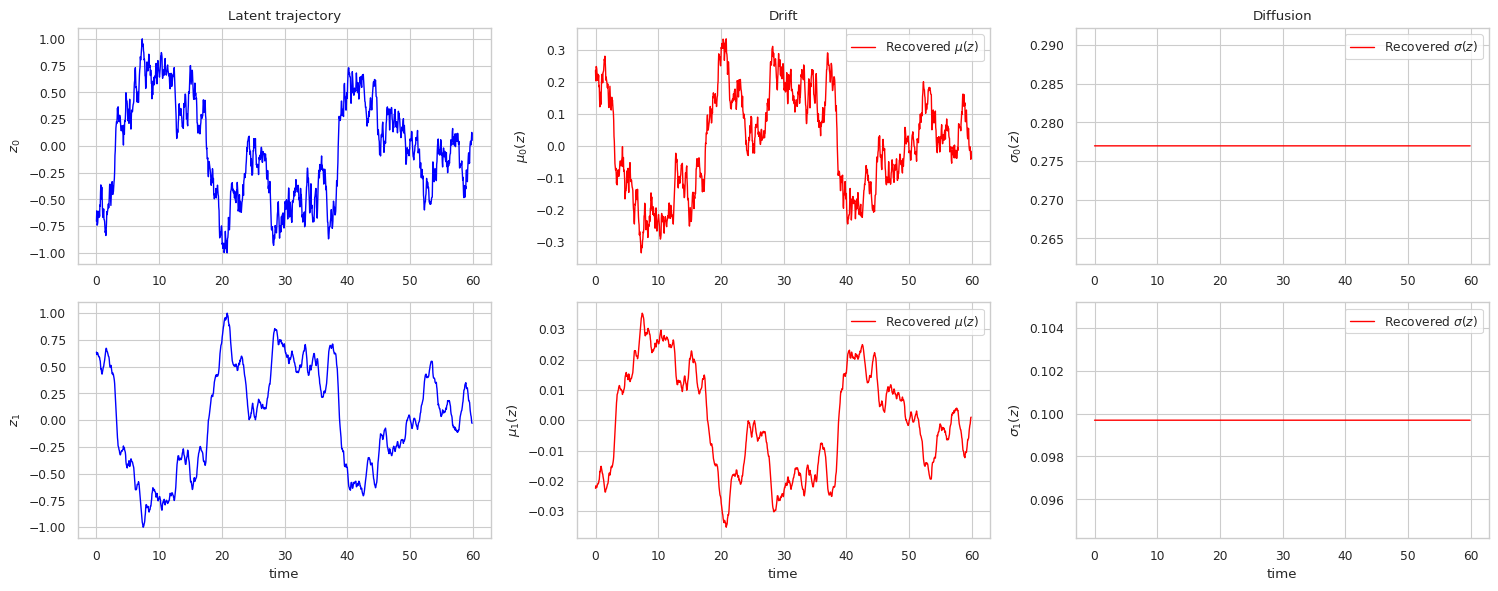


TRUE DRIFT EQUATIONS (deterministic part):
dx/dt = -0.5*x
dy/dt = -0.3*y

(Stochastic term sigma*dW is not recovered by SINDy)


In [13]:
# Perform SINDy identification
model.stochastic_sindy_identify(
    mu_degree=1,
    sigma_degree=0,
    method="girsanov",
    # Same params as original notebook
    sigma_threshold=0.0,
    sigma_alpha=0.05,
    mu_threshold=0.0,
    mu_alpha=0.05)

print("\n" + "="*50)
print("TRUE DRIFT EQUATIONS (deterministic part):")
print("="*50)
print(f"dx/dt = -{theta[0]}*x")
print(f"dy/dt = -{theta[1]}*y")
print("\n(Stochastic term sigma*dW is not recovered by SINDy)")

In [14]:
# Auto-tune threshold
best_threshold, results = model.auto_tune_threshold(adaptive=True)
print(f"\nBest threshold: {best_threshold}")

Computing least-squares solution to determine threshold range...
Max |coefficient|: 3.4805
Max threshold (scale_factor=0.3): 1.0441
Testing 10 thresholds: [0.         0.11601632 0.23203265 0.34804897 0.4640653  0.58008162
 0.69609795 0.81211427 0.92813059 1.04414692]
Testing threshold=0.000... sparsity=6, stable, MSE=3.6575e-01
Testing threshold=0.116... sparsity=4, stable, MSE=3.4558e-01
Testing threshold=0.232... sparsity=4, stable, MSE=3.4558e-01
Testing threshold=0.348... sparsity=4, stable, MSE=3.4558e-01
Testing threshold=0.464... sparsity=4, stable, MSE=3.4558e-01
Testing threshold=0.580... sparsity=4, stable, MSE=3.4558e-01
Testing threshold=0.696... sparsity=4, stable, MSE=3.4558e-01
Testing threshold=0.812... sparsity=4, stable, MSE=3.4558e-01
Testing threshold=0.928... sparsity=4, stable, MSE=3.4558e-01
Testing threshold=1.044... sparsity=4, stable, MSE=3.4558e-01

Best threshold: 0.116 (sparsity=4, MSE=3.4558e-01)
SINDy-derived dynamical equation (1st order):

(x0)' =  3.09

## 5. Evaluation

Note: Forecasting an SDE with only the drift term will show mean behavior but miss stochastic fluctuations.

In [15]:
# Forecast using identified model (deterministic)
n_forecast = min(200, n_time - train_length - validate_length - 30)
forecast = model.forecast(n_steps=n_forecast)

print(f"Forecast shape: {forecast.shape}")

Forecast shape: (200, 20)


In [16]:
# Compute reconstruction error on test set
test_start = train_length + validate_length + 30
test_data = data[test_start:test_start + n_forecast]

relative_error = np.linalg.norm(forecast - test_data) / np.linalg.norm(test_data)
print(f"Test set relative reconstruction error: {relative_error:.4f}")
print("\nNote: Higher error expected due to stochastic component not captured.")

Test set relative reconstruction error: 1.0576

Note: Higher error expected due to stochastic component not captured.


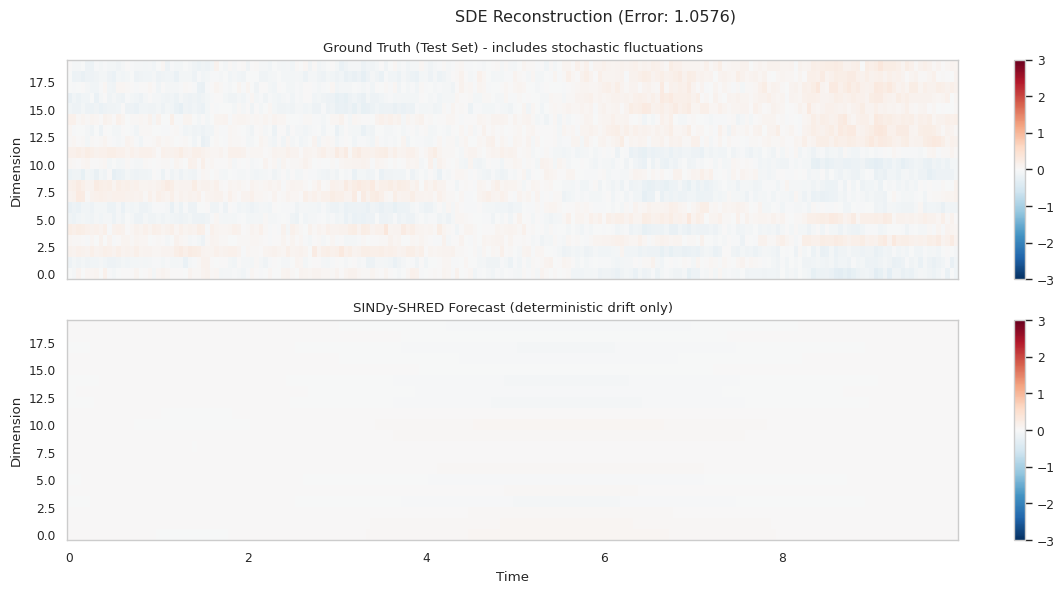

In [17]:
# Visualize reconstruction
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

t_test = np.arange(n_forecast) * dt

ax = axes[0]
im = ax.pcolormesh(t_test, np.arange(high_dim), test_data.T, **pcolor_kwargs)
ax.set_title("Ground Truth (Test Set) - includes stochastic fluctuations")
ax.set_ylabel("Dimension")
plt.colorbar(im, ax=ax)

ax = axes[1]
im = ax.pcolormesh(t_test, np.arange(high_dim), forecast.T, **pcolor_kwargs)
ax.set_title("SINDy-SHRED Forecast (deterministic drift only)")
ax.set_ylabel("Dimension")
ax.set_xlabel("Time")
plt.colorbar(im, ax=ax)

fig.suptitle(f"SDE Reconstruction (Error: {relative_error:.4f})")
fig.tight_layout()
fig.savefig(f"{RESULTS_DIR}/reconstruction.pdf", bbox_inches="tight", dpi=300)
plt.show()

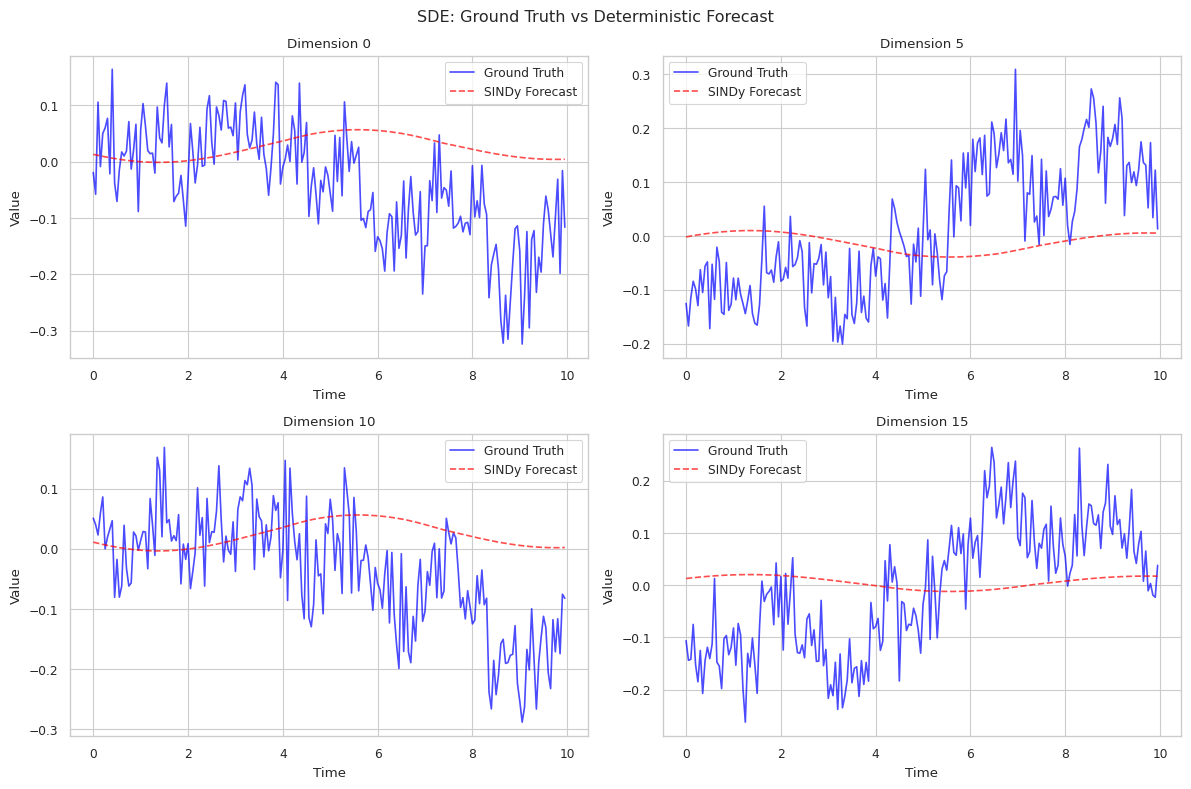

In [18]:
# Compare individual channels
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for idx, dim in enumerate([0, 5, 10, 15]):
    ax = axes[idx // 2, idx % 2]
    ax.plot(t_test, test_data[:, dim], 'b-', alpha=0.7, label='Ground Truth')
    ax.plot(t_test, forecast[:, dim], 'r--', alpha=0.7, label='SINDy Forecast')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Dimension {dim}')
    ax.legend()

fig.suptitle('SDE: Ground Truth vs Deterministic Forecast')
fig.tight_layout()
fig.savefig(f"{RESULTS_DIR}/channel_comparison.pdf", bbox_inches="tight", dpi=300)
plt.show()

## 6. Summary

This notebook demonstrated SINDy-SHRED on a **stochastic differential equation** (2D Ornstein-Uhlenbeck process):

- **True system:** $dX = -\theta X \, dt + \sigma \, dW$
- **Latent dimension:** 2
- **Observation dimension:** 20 (linear projection)

**Key observations:**
1. SINDy-SHRED successfully recovered the **deterministic drift** ($-\theta X$)
2. The **stochastic diffusion** ($\sigma \, dW$) is not explicitly captured
3. Forecasts track the mean behavior but miss stochastic fluctuations

**Future directions:**
- Extend to SINDy with diffusion term identification
- Uncertainty quantification in latent space
- Stochastic SINDy methods